# Simple regression PoC

In this notebook we try to use the library instead of putting everything in a notebook

In [1]:
from typing import NamedTuple
import chex
import jax
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp
from pcv.inference import fold_posterior, inference_loop, estimate_elpd, rhat_summary, mv_ess_folds, pred_ess_folds
from pcv.welford import *
import arviz as az
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

## Model definition

Gaussian linear regression

In [2]:
class Theta(NamedTuple):
    beta: chex.Array
    sigsq: chex.Array

In [3]:
y_key, X_key = jax.random.split(jax.random.PRNGKey(0))
N = 100
beta0 = jnp.array([1.0, 2.0, 3.0, 4.0])
p = len(beta0)
sigsq0 = jnp.array(2.0)
X = tfd.Normal(loc=0, scale=1).sample(sample_shape=(N, p), seed=X_key)
y = X@beta0 + tfd.Normal(loc=0, scale=jnp.sqrt(sigsq0)).sample(sample_shape=(N,), seed=y_key)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


To break inference, simply inject an outlier into the data. Remember jax arrays are immutable so we need this stange syntax.

In [4]:
# y = y.at[23].set(75.0)  # outlier

In [5]:
# use exp to transform sigsq to unconstrained space
sigsq_t = tfb.Exp()

beta_prior = tfd.MultivariateNormalDiag(loc=jnp.zeros(p), scale_diag=jnp.ones(p))
sigsq_prior = tfd.Gamma(concentration=1.0, rate=1.0)


def logjoint_density(theta: Theta, fold_id: int = -1) -> chex.Array:
    """Log joint density for a given fold.
    
    Args:
      theta: model parameters
      fold_id: zero-based fold id for training set, use -1 for all data.
    """
    # transform to constrained space
    sigsq = sigsq_t.forward(theta.sigsq)
    sigsq_ldj = sigsq_t.forward_log_det_jacobian(theta.sigsq)
    # prior is same for all folds
    lp = beta_prior.log_prob(theta.beta) + sigsq_prior.log_prob(sigsq)
    # likelihood for fold
    mask = 1.0 * ((jnp.arange(N) % 5) != fold_id)
    ll_contribs = tfd.Normal(loc=X@theta.beta, scale=jnp.sqrt(sigsq)).log_prob(y)
    ll = (mask * ll_contribs).sum()
    return lp + ll


# within-sample density log p(y|theta)
def log_p(theta):
    # transform to constrained space
    sigsq = sigsq_t.forward(theta.sigsq)
    esq = ((X @ theta.beta - y) ** 2).sum()
    return -0.5 * (
        N * jnp.log(2 * jnp.pi)
        + N * jnp.log(sigsq)
        + esq/sigsq
    )


# predictive density log p(y_train|theta)
def log_pred(theta, fold_id):
    # transform to constrained space
    sigsq = sigsq_t.forward(theta.sigsq)
    pred_mask = 1.0 * ((jnp.arange(N) % 5) == fold_id)
    npred = pred_mask.sum()
    esq = ((X @ theta.beta - y) ** 2) * pred_mask
    return -0.5 * (
        npred * jnp.log(2 * jnp.pi)
        + npred * jnp.log(sigsq)
        + esq.sum()/sigsq
    )


# random initialization in the constrained parameter space
def make_initial_pos(key):
    k1, k2 = jax.random.split(key)
    theta = Theta(
      beta=jax.random.normal(key=k1, shape=(p,)),
      sigsq=jax.random.normal(key=k2))
    return theta

## Inference

Ok let's actually run some MCMC

In [6]:
inference_key = jax.random.PRNGKey(42)

Run the full-data posterior with the offline inference loop, saving draws.

In [7]:
%%time

state, trace = fold_posterior(
    prng_key=inference_key,
    logjoint_density=lambda theta: logjoint_density(theta, -1),
    log_p=log_p,
    make_initial_pos=make_initial_pos,
    num_chains=10,
    num_samples=1000,
    warmup_iter=2000,
    online=False)

CPU times: user 6.57 s, sys: 37.9 ms, total: 6.61 s
Wall time: 6.57 s


Because we retained the draws, we can look at the pretty squiggles in Arviz.

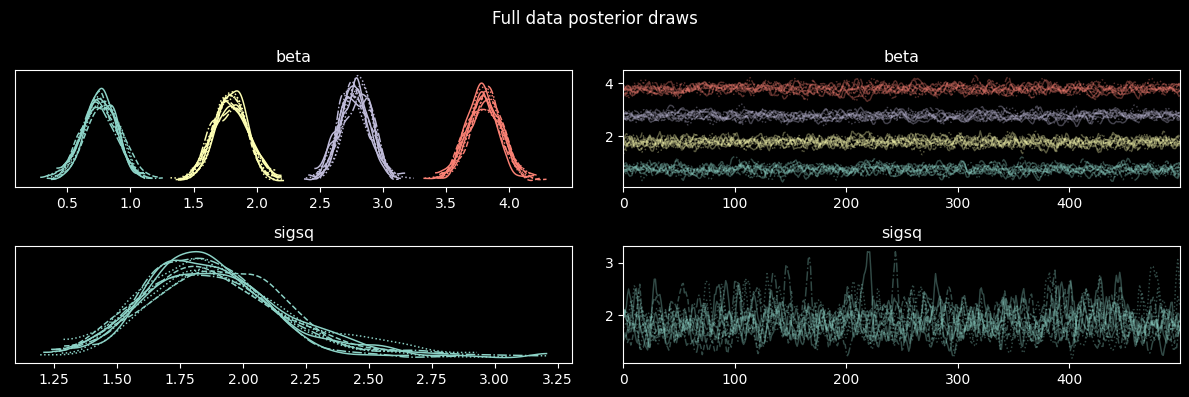

In [8]:
trace_az = az.convert_to_inference_data(dict(beta=trace.position.beta, sigsq=jax.vmap(sigsq_t.forward)(trace.position.sigsq)))
az.plot_trace(trace_az)
plt.suptitle('Full data posterior draws')
plt.tight_layout()

And now we'll do exactly the same thing with the online inference loop, which doesn't save the draws. In a different notebook we go through and check our rhat estimates match what Arviz comes up with, but let's not bother with that here.

In [9]:
%%time

online_state, _ = fold_posterior(
    prng_key=inference_key,
    logjoint_density=lambda theta: logjoint_density(theta, -1),
    log_p=log_p,
    make_initial_pos=make_initial_pos,
    num_chains=10,
    num_samples=1000,
    warmup_iter=2000,
    online=True)

CPU times: user 3.46 s, sys: 12.1 ms, total: 3.47 s
Wall time: 3.45 s


Smoke test the inference loop (no parallelism)

Ok, now we can do some cross validation. This is 5-fold CV and we'll run 5*10=50 chains.

In [10]:
%%time

def make_fold(fold_id):
    results = fold_posterior(
        prng_key=inference_key,
        logjoint_density=lambda theta: logjoint_density(theta, fold_id),
        log_p=lambda theta: log_pred(theta, fold_id),
        make_initial_pos=make_initial_pos,
        num_chains=10,
        num_samples=10_000,
        warmup_iter=2_000,
        online=True)
    return results

online_fold_states, _ = jax.vmap(make_fold)(jnp.arange(5))

_ = online_fold_states.rng_key.block_until_ready()

CPU times: user 7.49 s, sys: 21.7 ms, total: 7.51 s
Wall time: 7.47 s


Even though we discarded the draws we can still estimate elpd (and parameters for that matter)

In [11]:
estimate_elpd(online_fold_states)

-177.54055786132812

And Rhats

In [12]:
rhsumm = rhat_summary(online_fold_states)
rhsumm

,fold,measure,beta[0],beta[1],beta[2],beta[3],sigsq,log p
0,Fold 0,Rhat,1.000405,1.000225,1.000574,1.001451,1.000503,1.001395
1,Fold 0,Folded Rhat,1.000044,0.999979,1.000083,1.000234,1.000316,1.000669
2,Fold 1,Rhat,1.000515,1.000101,1.000470,1.002052,1.000876,1.000709
3,Fold 1,Folded Rhat,1.000338,1.000013,1.000162,1.000146,1.000421,1.000353
4,Fold 2,Rhat,1.000502,1.000114,1.000251,1.000991,1.000911,1.000479
5,Fold 2,Folded Rhat,1.000017,0.999971,1.000036,1.000215,1.000216,1.000398
6,Fold 3,Rhat,1.000310,1.000079,1.000608,1.000905,1.000584,1.000416
7,Fold 3,Folded Rhat,1.000034,0.999995,1.000162,1.000208,1.000261,1.000282
8,Fold 4,Rhat,1.000172,1.000367,1.001927,1.000963,1.000530,1.000499
9,Fold 4,Folded Rhat,0.999950,1.000059,1.000256,1.000154,1.000218,1.000056


Q: How well does the Vats and Knudson ESS estimate hold up? This is the asymptotic estimate, not their ESS ratio.

A: Not great. Negative Rhat sends it for a loop.

In [13]:
num_chains = 10
vkess = rhsumm.copy()
vars = rhsumm.columns[2:]
for var in vars:
    vkess[var] = round(num_chains/(rhsumm[var]**2 - 1),1)
vkess

,fold,measure,beta[0],beta[1],beta[2],beta[3],sigsq,log p
0,Fold 0,Rhat,12348.2,22177.8,8712.0,3442.5,9941.3,3581.8
1,Fold 0,Folded Rhat,113357.1,-234321.2,60001.8,21386.1,15819.1,7466.0
2,Fold 1,Rhat,9706.5,49634.2,10634.8,2433.9,5707.1,7050.3
3,Fold 1,Folded Rhat,14781.8,384796.0,30770.1,34292.7,11862.6,14157.9
4,Fold 2,Rhat,9950.8,43963.0,19885.1,5044.8,5488.1,10436.3
5,Fold 2,Folded Rhat,301746.0,-174401.8,139343.1,23221.8,23196.1,12574.1
6,Fold 3,Rhat,16141.9,63547.6,8218.4,5521.4,8560.8,12019.0
7,Fold 3,Folded Rhat,147166.1,-1103766.7,30860.7,24061.2,19158.3,17754.9
8,Fold 4,Rhat,29003.8,13606.5,2592.8,5189.8,9437.8,10012.6
9,Fold 4,Folded Rhat,-100585.3,84051.7,19515.0,32461.2,22980.0,90004.0


In [14]:
pred_ess_folds(online_fold_states)

Array([2333.1218, 3010.7483, 3151.2446, 2183.8552, 3153.7432], dtype=float32)

In [15]:
esss = mv_ess_folds(online_fold_states)
pesss = pred_ess_folds(online_fold_states)
for i, (ess, pess) in enumerate(zip(esss, pesss)):
    print(f"fold {i} multivariate parameter ess = {ess:.0f}, predictive ess = {pess:.0f}.")

fold 0 multivariate parameter ess = 2741, predictive ess = 2333.
fold 1 multivariate parameter ess = 2961, predictive ess = 3011.
fold 2 multivariate parameter ess = 2539, predictive ess = 3151.
fold 3 multivariate parameter ess = 2509, predictive ess = 2184.
fold 4 multivariate parameter ess = 2950, predictive ess = 3154.


## Offline inference replay

Suppose one of the folds misbehaves. Then what? Well, because we were careful with the prng state we can simply replay those 10 MCMC chains on the CPU and retain all the draws and play with them in Arviz.

In [16]:
def replay_fold(fold_id, inference_key=inference_key):
    results, trace = fold_posterior(
        prng_key=inference_key,
        logjoint_density=lambda theta: logjoint_density(theta, fold_id),
        log_p=lambda theta: log_pred(theta, fold_id),
        make_initial_pos=make_initial_pos,
        num_chains=10,
        num_samples=2000,
        warmup_iter=1000,
        online=False)
    pos = trace.position
    theta_dict = az.convert_to_inference_data(dict(beta=pos.beta, sigsq=jax.vmap(sigsq_t.forward)(pos.sigsq)))
    trace_az = az.convert_to_inference_data(theta_dict)
    return results, trace_az

In [17]:
fold4_state, fold4_trace = replay_fold(4)

In [18]:
az.summary(fold4_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.647,0.157,0.359,0.951,0.005,0.004,942.0,1419.0,1.01
beta[1],1.665,0.146,1.375,1.921,0.005,0.004,854.0,1497.0,1.01
beta[2],2.859,0.133,2.609,3.106,0.003,0.002,2271.0,3232.0,1.00
beta[3],3.729,0.152,3.439,4.013,0.003,0.002,2593.0,3905.0,1.00
sigsq,1.777,0.277,1.281,2.291,0.007,0.005,1532.0,2265.0,1.01


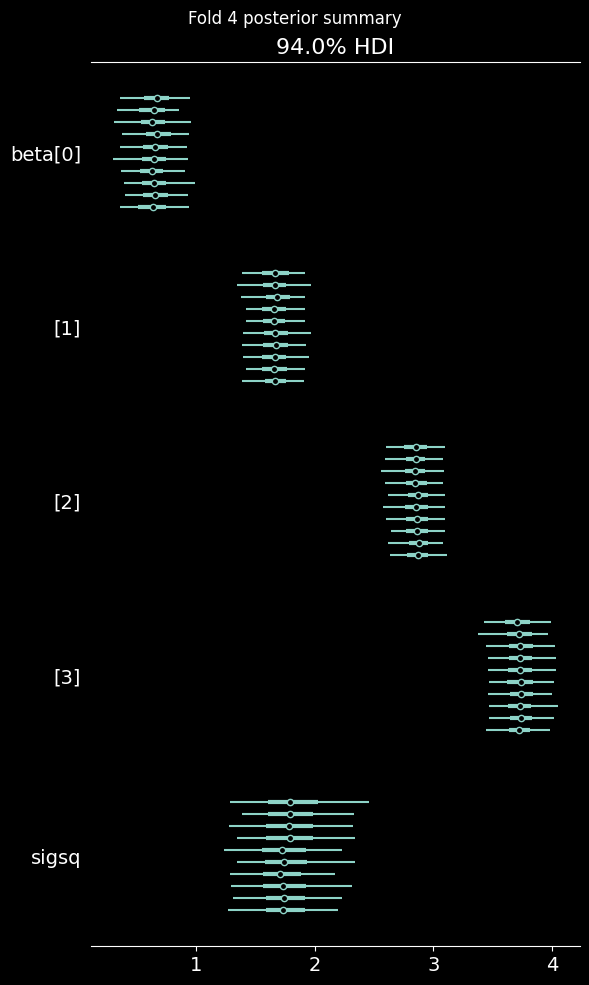

In [19]:
az.plot_forest(fold4_trace)
plt.suptitle(f"Fold 4 posterior summary")
plt.tight_layout()

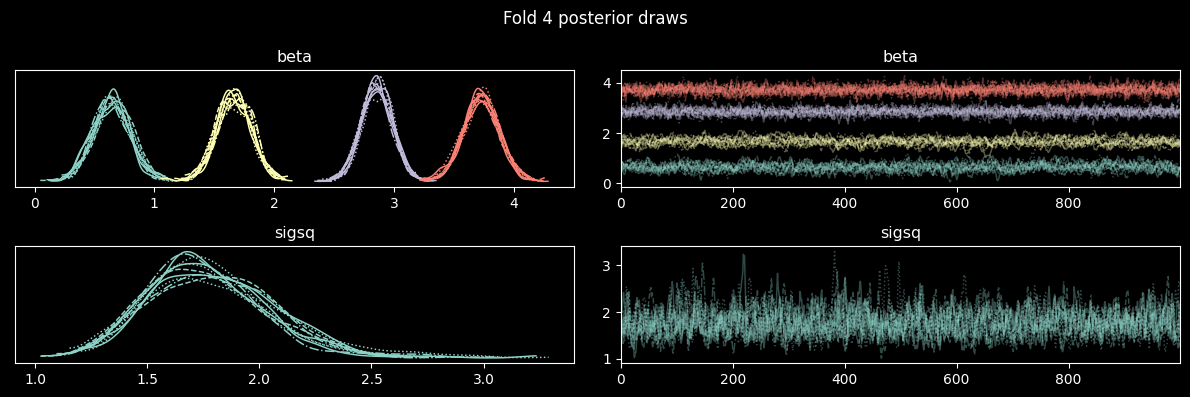

In [20]:
az.plot_trace(fold4_trace);
plt.suptitle('Fold 4 posterior draws')
plt.tight_layout()